# Stroke Prediction 

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading in the data and getting a simple overview of it

In [90]:
data = pd.read_csv('C:\\Users\\Tyron\\OneDrive\\Desktop\\Machine Learning Projects\\Machine-Learning-Projects\\Stroke_Prediction\\healthcare-dataset-stroke-data.csv')
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [92]:
data.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [93]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Data Preprocessing

#### Splitting the data into train and test sets

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
data = data[data['gender'] != 'Other']
X = data.drop(['stroke', 'id'], axis=1)
y = data['stroke']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

In [97]:
print('X_Train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_Train:  (4342, 10)
X_test:  (767, 10)
y_train:  (4342,)
y_test:  (767,)


### Creating a Pipeline to automate data preprocessing

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [99]:
class Stroke_Pipeline():
    def __init__(self, data):
        self.data = data
        self.num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
        self.cat_pipeline = make_pipeline(OneHotEncoder())
    
    def transform(self):
        num_attrib = self.data.select_dtypes(['int64', 'float64']).columns
        cat_attrib = self.data.select_dtypes('object').columns

        pipe = ColumnTransformer([
            ('num', self.num_pipeline, num_attrib),
            ('cat', self.cat_pipeline, cat_attrib)
        ])

        piped_data = pipe.fit_transform(self.data)
        return pd.DataFrame(piped_data, columns=pipe.get_feature_names_out())

In [100]:
X_train = Stroke_Pipeline(X_train).transform()

### Model Selection 

In [101]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [106]:
rfc_params = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
}

rfc_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rfc_params)
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [110]:
print('Best Score :' , rfc_grid.best_score_)
print('BEst Params:' , rfc_grid.best_params_)

Best Score : 0.9537081130384519
BEst Params: {'criterion': 'gini', 'n_estimators': 200}


### Model Creation

In [112]:
RFC = RandomForestClassifier(n_estimators=200, criterion='gini')
RFC.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

###  Model Evaluation

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

#### Evaluation on Training Data

In [103]:
X_test = Stroke_Pipeline(X_test).transform()

In [113]:
train_pred = RFC.predict(X_train)
test_pred = RFC.predict(X_test)

<AxesSubplot: >

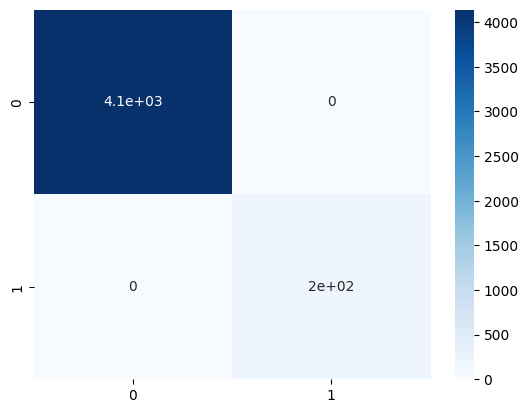

In [117]:
train_conf_matrix = confusion_matrix(y_true=y_train, y_pred=train_pred)
sns.heatmap(train_conf_matrix, annot=True, cmap='Blues')

In [ ]:
test_conf_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred)
sns.heatmap(test_conf_matrix, annot=True, cmap='Blues')

#### Evaluation on Test Data

### Saving the model